[Reference](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

In [2]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 17.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=c405b4911fe0fb223b8798b0e52bc6a615a54e73ec31a6371157fe4e3eaa637d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=7556cfb4f1ed0bec039e70468e56534ce713af5c16f7e1eada391df749ce4197
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [4]:
df.head(15)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns
6,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3,comp.sys.ibm.pc.hardware
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2,comp.os.ms-windows.misc
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4,comp.sys.mac.hardware


In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: Dep

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['where s thing subject car nntp post host line wonder out could enlighten car see other day door sport car look late early call door really small addition front bumper separate rest body know can tellme model name engine specs year production where car make history info funky look car mail thank bring neighborhood lerxst', 'poll final call summary final call clock report acceleration post fair number brave soul upgrade si clock oscillator share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy especially request will summarize next day so add network knowledge base do clock upgrade answer poll thank']


In [8]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [9]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.8435355668648374 %


In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -7597237.840707324
Perplexity:  1649.0540972672636
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [12]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -1597325.7494123087
Model Perplexity:  1568.696290257395


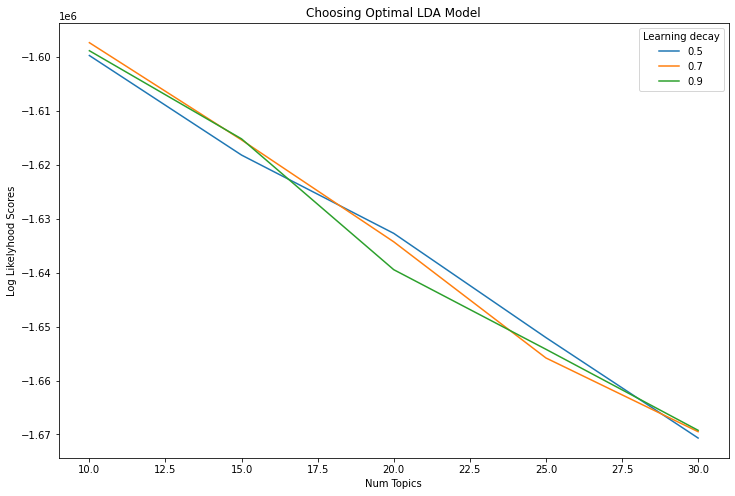

In [28]:
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [29]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.210000,0.540000,0.000000,0.230000,0.000000,0.000000,5
Doc1,0.100000,0.000000,0.000000,0.000000,0.090000,0.000000,0.160000,0.640000,0.000000,0.000000,7
Doc2,0.000000,0.020000,0.080000,0.000000,0.160000,0.050000,0.060000,0.570000,0.060000,0.000000,7
Doc3,0.000000,0.170000,0.000000,0.000000,0.340000,0.000000,0.000000,0.480000,0.000000,0.000000,7
Doc4,0.500000,0.000000,0.150000,0.000000,0.260000,0.000000,0.000000,0.000000,0.080000,0.000000,0
Doc5,0.000000,0.000000,0.130000,0.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc6,0.250000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000,0.420000,0.000000,0.200000,7
Doc7,0.210000,0.070000,0.000000,0.000000,0.000000,0.000000,0.600000,0.110000,0.000000,0.000000,6
Doc8,0.850000,0.010000,0.010000,0.010000,0.100000,0.010000,0.010000,0.010000,0.010000,0.010000,0
Doc9,0.270000,0.000000,0.000000,0.000000,0.070000,0.000000,0.210000,0.440000,0.000000,0.000000,7


In [30]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,2112
1,2,2019
2,0,1403
3,5,1330
4,4,1261
5,9,978
6,1,660
7,8,618
8,3,473
9,6,460


In [31]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  20.977247
0       0.648955  71.707100       2        1  12.705762
9      71.019684   9.971006       3        1  12.099336
5       3.785981  33.185135       4        1  10.735258
7     -42.666500  -9.222070       5        1   9.333330
4      -3.621689 -43.526516       6        1   8.320333
1      -3.632402  -4.171708       7        1   7.475909
8     -36.584400  35.804413       8        1   7.306473
3      44.391380  50.615383       9        1   6.696198
6      40.235809 -31.591665      10        1   4.350153, topic_info=         Term         Freq        Total Category  logprob  loglift
3906      max  3866.000000  3866.000000  Default  30.0000  30.0000
2011    drive  2271.000000  2271.000000  Default  29.0000  29.0000
3543      key  2058.000000  2058.000000  Default  28.0000  28.0000
2496     file  2961.000000  2961.000000  Default  27.0000  27.0000
2880      gun  1674.000000  1674.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
6493     time   263.632885  4880.238125  Topic10  -5.1312   0.2166
7107     year   233.809101  3926.182132  Topic10  -5.2513   0.3140
3530     just   235.827795  5576.661822  Topic10  -5.2427  -0.0283
371   article   237.853013  6865.255462  Topic10  -5.2341  -0.2276
3834     make   231.941616  5894.883409  Topic10  -5.2593  -0.1004

[809 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
15        1  0.937599  absolute
15        2  0.010456  absolute
15        3  0.027884  absolute
15        4  0.010456  absolute
15        7  0.010456  absolute
...     ...       ...       ...
7107      7  0.040752      year
7107      8  0.106465      year
7107      9  0.051195      year
7107     10  0.059600      year
7109      3  0.994173     yeast

[2561 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 10, 6, 8, 5, 2, 9, 4, 7])

In [32]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abandon,abbreviation,abide,abiding,ability,able,abolish,abomination,abort,abortion,abpsoft,abroad,abs,absence,absent,absolute,absolutely,absorb,abstinence,abstract,absurd,absurdity,abundant,abuse,abusive,abyss,academia,academic,accelerate,accelerated,acceleration,accelerator,accept,acceptable,acceptance,access,accessible,accessory,accident,accidental,...,worthy,wound,wrap,wrath,wreck,wrench,wrist,write,writer,writing,wrong,wrongful,wuarchive,xaw,ximage,xlib,xor,xputimage,xserver,xterm,xview,yard,year,yearly,yeast,yell,yellow,yesterday,yield,young,youngster,yourselfer,youth,zinc,zionism,zionist,zip,zone,zoology,zoom
Topic0,1.367736,6.439560,0.100002,0.100005,32.297608,148.935151,0.100001,0.100000,10.434679,0.100003,15.099959,15.860431,1.313732,1.218339,0.100036,3.050013,6.492659,1.348051,0.100000,4.836212,0.101256,0.100014,0.100001,26.115639,0.100154,0.100000,4.157699,0.145693,0.550268,2.362351,0.100004,49.992590,68.475630,19.322075,4.631789,278.956996,8.711279,9.243057,0.100003,0.100004,...,0.100012,0.100000,14.302102,0.100015,0.100005,0.100002,9.123543,999.932702,19.857618,10.869509,74.219572,0.100000,20.04668,31.099994,22.099992,78.099993,8.242881,36.981832,23.099980,30.099991,53.099986,0.100000,9.435226,0.100002,0.100000,1.209144,1.664884,0.100008,8.965278,10.958182,0.100000,0.100005,0.100004,8.169112,0.100000,0.100000,58.354564,0.100075,0.100005,19.419015
Topic1,0.100006,0.100035,18.334835,0.100055,60.054018,108.779583,0.100037,0.100000,0.100006,3.659955,0.100000,0.100706,0.100000,3.992993,3.982552,3.205828,15.612731,0.146596,0.100000,4.664139,1.178572,0.100002,0.100003,27.311145,0.100010,0.100024,6.301711,12.694080,10.734462,0.100002,0.100005,0.100005,12.328535,7.069900,27.850745,280.127976,0.100038,0.101066,0.143187,0.100013,...,0.100049,0.100005,1.237559,0.100032,0.100253,0.100000,0.100008,673.260141,0.100011,0.100013,61.633768,0.100012,0.10000,0.100000,0.100000,0.100001,28.957089,0.100000,0.100000,0.100003,0.100000,0.100005,166.247394,0.100007,0.100001,0.100035,0.100013,1.480307,1.406480,0.100003,0.100000,0.100012,0.100002,0.100029,0.100001,0.100001,5.228987,0.100002,11.145605,0.120412
Topic2,36.920504,0.100030,3.357158,0.100028,90.535678,190.854295,31.421452,3.576850,0.100020,103.774373,0.100000,6.144996,0.100005,29.375750,10.772319,270.454886,94.839118,8.398466,11.528800,11.389757,35.367910,18.599801,7.541270,65.266157,0.100093,0.100061,0.100026,10.478102,0.100003,0.100026,0.100001,0.100002,521.397749,50.407330,24.372119,25.703576,1.266327,0.100001,14.673728,2.737569,...,49.642111,2.333186,3.649482,11.047152,7.150715,0.100000,0.100000,2807.484201,62.304033,95.065283,536.055975,0.100007,0.10000,0.100000,0.100000,0.100000,0.100001,0.100000,0.100001,0.100000,0.100000,0.100005,352.653261,0.100002,0.100009,4.205879,0.100015,23.405580,0.100093,72.810475,3.351938,0.100057,7.705298,0.100002,45.948435,61.099927,0.100004,0.410022,0.100004,0.100008
Topic3,0.100041,0.100010,54.607975,13.094829,7.317948,28.839576,0.100129,0.100109,0.100033,6.378946,0.100000,0.100023,0.100000,3.754983,2.466664,0.100016,3.080205,0.100525,0.100007,10.699528,5.141196,0.100018,0.100001,85.706036,0.336933,0.100158,0.100080,0.100026,0.100001,0.100046,0.100003,0.100000,7.438776,30.413663,0.100014,31.200256,3.063074,0.113070,63.156876,29.313054,...,0.100050,28.982466,0.100037,2.867860,0.100025,0.100001,0.100000,450.105734,0.100021,0.100012,51.255564,12.099968,0.10000,0.100000,0.100000,0.100000,0.100003,0.100001,0.100000,0.100000,0.100000,1.385901,199.366275,0.100008,0.100000,0.119769,0.100008,0.100025,7.799378,8.712071,0.100006,0.100028,0.100040,0.100000,0.100002,0.100006,13.700118,23.533729,0.100007,1.729080
Topic4,0.100009,9.875427,0.100000,0.100001,29.153149,60.906652,2.422653,0.100005,0.100006,0.100010,0.100000,0.100009,2.640298,0.100006,3.234967,0.100023,26.134193,0.100001,0.100000,1.010432,0.100047,0.100049,0.100000,4.185563,0.100014,0.100015,0.100016,0.104134,0.100002,0.100001,0.100004,0.100001,5.964175,3.213705,0.100029,12.683663,0.100020,0.10000

In [33]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,use,file,window,program,line,image,write,run,version,available,problem,software,work,server,include
Topic 1,key,use,chip,encryption,clipper,line,write,government,make,bit,public,phone,know,article,need
Topic 2,say,write,people,think,know,make,line,article,believe,just,subject,thing,question,come,way
Topic 3,max,gun,law,right,government,state,people,weapon,use,crime,firearm,write,police,make,control
Topic 4,game,team,line,year,write,win,think,good,player,article,post,play,make,say,just
Topic 5,car,say,write,line,just,article,know,time,think,subject,bike,come,good,look,thing
Topic 6,drive,disk,scsi,card,driver,hard,problem,line,use,write,play,controller,bus,work,tape
Topic 7,line,post,subject,use,nntp,write,thank,know,article,host,need,distribution,card,just,reply
Topic 8,space,mail,sale,list,include,information,send,post,line,launch,new,address,offer,price,year
Topic 9,people,year,say,work,write,turkish,article,make,time,know,line,armenian,use,think,food


In [34]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['use', 'file', 'window', 'program', 'line', 'image', 'write', 'run', 'version', 'available', 'problem', 'software', 'work', 'server', 'include']


In [35]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.29  0.1   0.65  0.08  0.19  0.23  0.1   0.57  0.14  0.16]
 [-0.32 -0.05  0.72  0.03 -0.03 -0.11 -0.09 -0.59 -0.05  0.02]]
Perc of Variance Explained: 
 [0.05 0.23]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

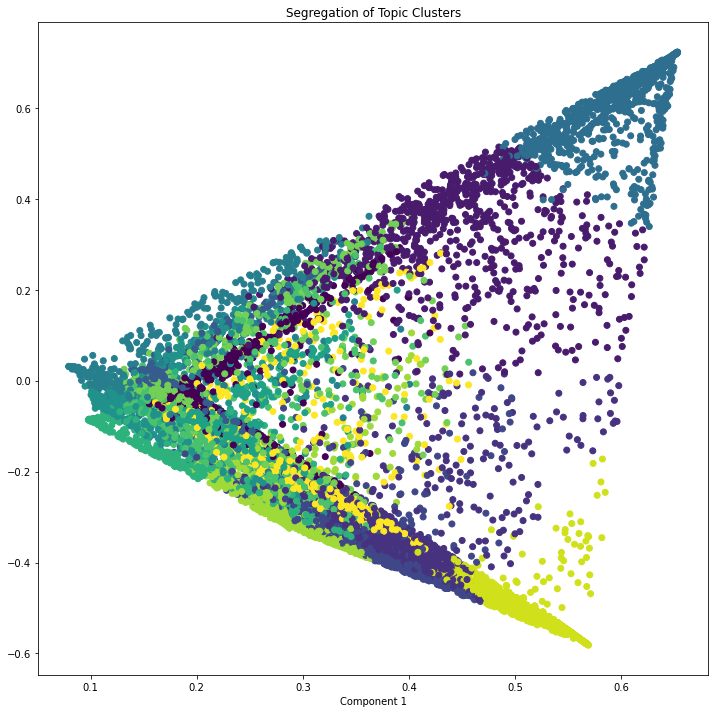

In [36]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [37]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [38]:
# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['use', 'file', 'window', 'program', 'line', 'image', 'write', 'run', 'version', 'available', 'problem', 'software', 'work', 'server', 'include']
Topic Prob Scores of text:  [[0.5 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
Most Similar Doc's Probs:   [[0.7 0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

 From: (stockman harlan w) Subject: hp2xx for DOS Organization: Sandia National Laboratories Lines: 3 Is there a precompiled version of hp2xx for DOS out there - prefereably for 386/486? 
